### DFHMC ###

* Works the same as DFMD
* Filtered velocity is used as the mean in a bimodal distribution (vfil, -vfil)
* Velocity drawn from this distribution is used as the filtered velocity
* Accepted or rejected after a certain number of steps

In [1]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
%matplotlib inline

**Bimodal function**
* Filtered velocity is used as the mean
* Doesn't seem to work too well when $\sqrt{\frac{kT}{m}}$ is used as standard deviation as all values seem to be in one of two bins

In [2]:
# Want a function that draws from a bimodal distribution
def Bimodal(vfil, T=298, m=1):
    k = float(1.381e-23) # J k^-1
    # sigma = np.sqrt(((k * T)/ m))
    sigma = 0.01 # standard deviation
    a = np.random.uniform(0, 1) # draws a random number: decides if +ve or -ve distribution is used
    if a > 0.5: # use the +ve distribution
        v = np.random.normal(vfil, sigma)
    else: # use the -ve distribution
        v = np.random.normal(-vfil, sigma)
    return v

In [3]:
P = []
for n in range(10000):
    p = Bimodal(0.1)
    P.append(p)

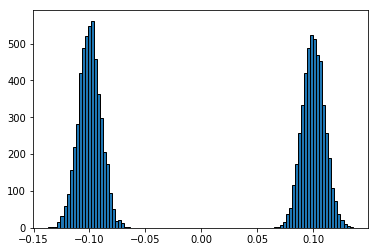

In [4]:
plt.hist(P, 100, edgecolor='black');

In [5]:
# FILTER FUNCTIONS

# Design Filter
def Filter(numtaps, bands, desired):
    """
        Provides filter coefficients for DFMD
        ---------------
        PARAMETERS
        ---------------
        numtaps:length of the filter, must be odd
        bands: desired bands of the filter, must be in pairs, list
        desired: the desired frequency response of the filter, must have the same number of values as bands, list
    """
    Coeff = sp.firls(numtaps, bands, desired)
    return Coeff

# Frequency Response of the Filter
def FreqResponse(coeff, lim=None):
    freq1, response = sp.freqz(coeff)
    plt.plot(freq1/np.pi, np.abs(response), 'r') # added nyq here
    plt.xlim(lim)
    plt.xlabel('f / nyq_f')
    plt.ylabel('Relative amplitudes')

# Applies the Filter
def ApplyFilter(signal, coeff): # multiplies signal and coeffs and adds them together to get a single value
    """
        Multiplies a signal and coefficients and adds them together to get a single filtered value
        ---------------
        PARAMETERS
        ---------------
        signal: input signal to be filtered
        coeff: filter coefficients
    """
    a = len(coeff)
    Filtered = np.sum(np.array(signal[0:a])*np.array(coeff))
    return Filtered

In [6]:
def ScalarProduct(vector1, vector2):
    Prod = []
    N = len(vector1)
    for n in range(N):
        Prod.append(vector1[n] * vector2[n])
    return np.sum(Prod)

In [7]:
def F(r, k=100):
    """
        Force on a particle in a Harmonic Oscillator
    """
    f = -k * r
    return f

def Kinetic(x_trj, y_trj):
    kin = []
    if type(x_trj) == int and type(y_trj) == int:
        x = x_trj
        y = y_trj
        return (0.5 * 1 * (x ** 2)) + (0.5 * 1 * (y ** 2))
    elif type(x_trj) == float and type(y_trj) == float:
        x = x_trj
        y = y_trj
        return (0.5 * 1 * (x ** 2)) + (0.5 * 1 * (y ** 2))
    else:
        for n in range(len(x_trj)):
            x = x_trj[n]
            y = y_trj[n]
            kin.append((0.5 * 1 * (x ** 2)) + (0.5 * 1 * (y ** 2)))
        return kin

def Potential(x_trj, y_trj, k1, k2):  # need x and y input from MD trajectory
    pot = []
    if type(x_trj) == int and type(y_trj) == int:
        x = x_trj
        y = y_trj
        return (0.5 * k1 * (x ** 2)) + (0.5 * k2 * (y ** 2))
    elif type(x_trj) == float and type(y_trj) == float:
        x = x_trj
        y = y_trj
        return (0.5 * k1 * (x ** 2)) + (0.5 * k2 * (y ** 2))
    else:
        for n in range(len(x_trj)):
            x = x_trj[n]
            y = y_trj[n]
            pot.append((0.5 * k1 * (x ** 2)) + (0.5 * k2 * (y ** 2))) 
        return pot

In [8]:
#-------------------------
#          TO DO
#-------------------------
# * Change Buffer function so that takes x and y components and returns the desired values [DONE]
# * Have a different k value for the x and y components or some way of setting these in the function [DONE]
# * Change code after finding distribution so it's like HMC [DONE]
# * Calculate momentum? If not remove mass as parameter [DONE]
# * Accept/Reject count to give an acceptance rate [DONE]
# * Trajectories to be collected during HMC [DONE]
# * Write the code for an acceptance part of the algorithm []
# * Run tests to see if it's working correctly []
# * Make corrections []
# * Can acceptance be a function instead of multiple lines of code? []

def MD(r, v, t, dt, m=1):
    v = v + (dt / (2 * m)) * F(r)
    r = r + (dt * v)
    v = v + (dt / (2 * m)) * F(r)
    t = t + dt
    return v, r, t

def Buffer(coeff, rx, ry, vx, vy, t, dt, m=1):
    Buffer = len(coeff)
    buffx = []
    buffy = []
    rx_buff = []
    ry_buff = []
    for md in range(Buffer):
        trjx = MD(rx, vx, t, dt, m=m)
        trjy = MD(ry, vy, t, dt, m=m)
        buffx.append(trjx[0])
        buffy.append(trjy[0])
        rx_buff.append(trjx[1])
        ry_buff.append(trjy[1])
        vx, vy = trjx[0], trjy[0]
        rx, ry = trjx[1], trjy[1]
        t = trjx[2]
            
        if len(buffx) == Buffer:
            vx_fil = ApplyFilter(buffx, coeff)
            vy_fil = ApplyFilter(buffy, coeff)
            mid_rx = rx_buff[(Buffer+1)/2]
            mid_ry = ry_buff[(Buffer+1)/2]
    return mid_rx, mid_ry, vx_fil, vy_fil
        
    
def DFHMC(rx, ry, vx, vy, t, dt, MDStep, Total, coeff, L, k1=100, k2=10, kT=1, mass=1, temp=298):
    """
        DFHMC Algorithm
        ---------------
        PARAMETERS
        ---------------
        rx: initial x position
        ry: initial y position
        vx: initial x velocity
        vy: initial y velocity
        t: time
        dt: time step
        MDStep: number of steps before the filter is applied
        Total: total number of steps for the algorithm
        coeff: filter coefficients
        L = loops of verlet between each acceptance teset
        k1: force constant 1, default at 100
        k2: force constant 2, default at 10
        kT: Boltzmann constant * Temperature, default at 1
        mass: mass of particle, default at 1
        temp: temperature, default at 298 K
        ---------------
        RETURNS
        ---------------
        vx_trj: x velocity trajectory
        vy_trj: y velocity trajectory
        rx_trj: x position trajecoty
        ry_trj: y position trajecoty
        t_trj: time trajectory
        kin: kinetic energy
        pot: potential energy
    """
    # Set up trajectories and append the initial values
    vx_trj = [vx]
    rx_trj = [rx]
    vy_trj = [vy]
    ry_trj = [ry]
    t_trj = [t]
    mid = (len(coeff)+1)/2
    
    #Counts accept/reject
    Accept = 0
    Reject = 0
    
    # MD runs for a given number of steps before the buffer starts to fill
    for md in range(MDStep):
        trjx = MD(rx, vx, t, dt, m=mass)
        trjy = MD(ry, vy, t, dt, m=mass)
        vx_trj.append(trjx[0])
        rx_trj.append(trjx[1])
        vy_trj.append(trjy[0])
        ry_trj.append(trjy[1])
        t_trj.append(trjx[2])
        vx, vy = trjx[0], trjy[0]
        rx, ry = trjx[1], trjy[1]
        t = trjx[2]
    
    # Filter to find the bimodal distribution
    mid_rx, mid_ry, vx_fil, vy_fil = Buffer(coeff, rx, ry, vx, vy, t, dt, m=mass)
    
    vfil = [vx_fil, vy_fil]
    
    # Adds the first half of the first buffer to the trajectories
    for md in range(mid):
        trjx = MD(rx, vx, t, dt, m=mass)
        trjy = MD(ry, vy, t, dt, m=mass)
        vx_trj.append(trjx[0])
        rx_trj.append(trjx[1])
        vy_trj.append(trjy[0])
        ry_trj.append(trjy[1])
        t_trj.append(trjx[2])
        vx, vy = trjx[0], trjy[0]
        rx, ry = trjx[1], trjy[1]
        t = trjx[2]
    
    for md in range(int((Total - mid - MDStep)/L)):
        # Draws a random velocity from bimodal distribution centred at +-vfil
        vx = Bimodal(vx_fil, T=temp, m=mass)
        vy = Bimodal(vy_fil, T=temp, m=mass)
        rx_init = rx
        ry_init = ry
        t_init = t
        
        # proposed trajectories
        vx_prop = [vx]
        vy_prop = [vy]
        rx_prop = [rx]
        ry_prop = [ry]
        t_prop = [t]
        
        px_init = mass * vx
        py_init = mass * vy
        p_init = [px_init, py_init]
        
        # Calculates initial Hamiltonian for acceptance test
        H_init = Kinetic(vx, vy) + Potential(rx, ry, k1, k2)
        
        for l in range(L): # MD Step of HMC
            trjx = MD(rx, vx, t, dt, m=mass)
            trjy = MD(ry, vy, t, dt, m=mass)
            vx, vy = trjx[0], trjy[0]
            rx, ry = trjx[1], trjy[1]
            t = trjx[2]
             
            # Append to proposed trajectory
            vx_prop.append(vx)
            vy_prop.append(vy)
            rx_prop.append(rx)
            ry_prop.append(ry)
            t_prop.append(t)
        
        px_prop = mass * vx
        py_prop = mass * vy
        p_prop = [px_prop, py_prop]
        
        # Calculated proposed Hamiltonian for acceptance test
        H_prop = Kinetic(vx, vy) + Potential(rx, ry, k1, k2)
        
        # Acceptance probability
        # Problem here is only one momentum value, we have 2
        Pa = np.exp((ScalarProduct(vfil, p_prop))/kT) + np.exp((-ScalarProduct(vfil, p_prop)/kT))
        Pb = np.exp((ScalarProduct(vfil, p_init))/kT) + np.exp((-ScalarProduct(vfil, p_init)/kT))
        P = Pa / Pb
        Probability = min(1, np.exp((-(H_prop - H_init))/kT) * P)
        
        # Randomly accept
        if np.random.uniform(0, 1) > Probability:
            Reject += 1
            # initial positions used for next loop
            rx = rx_init
            ry = ry_init
            t = t_init
        else:
            Accept += 1
            # Extend the trajectories by the proposed trajectories, proposed values are used as starting conditions for
            # the next loop of the algorithm
            vx_trj.extend(vx_prop)
            vy_trj.extend(vy_prop)
            rx_trj.extend(rx_prop)
            ry_trj.extend(ry_prop)
            t_trj.extend(t_prop)
            
    kin = Kinetic(vx_trj, vy_trj)
    pot = Potential(rx_trj, ry_trj, k1, k2)
    
    print 'DFHMC Complete'
    print 'The Acceptance Rate Was', (float(Accept)/(Accept + Reject))*100, '%'
    return vx_trj, vy_trj, rx_trj, ry_trj, t_trj, kin, pot

In [9]:
coeff = Filter(1001, [0, 0.1, 0.11, 1], [1, 1, 0, 0])
# This filter will set the velocities to 0 so will essentially be sampling from a gaussian

In [12]:
vx_trj, vy_trj, rx_trj, ry_trj, t_trj, kin, pot = DFHMC(0, 0, 0.1, 0.1, 0, 0.01, 1000, 5000, coeff, 10)

DFHMC Complete
The Acceptance Rate Was 100.0 %


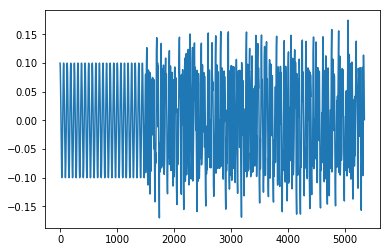

In [11]:
plt.plot(vx_trj)

(0, 5000)

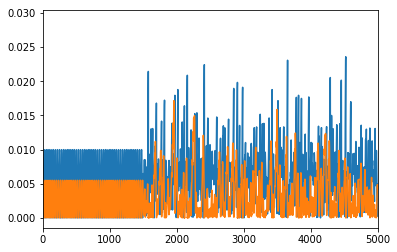

In [53]:
plt.plot(kin)
plt.plot(pot)
plt.xlim([0, 5000])